# Digits Classification

Building neural net (using `tensorflow` and `keras`) and ensemble tree (using `sklearn`) models to predict digit classification from images sourced from `tensorflow.nmist`. 

In [1]:
import logging

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.INFO)

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
import numpy as np

import matplotlib.pyplot as plt

from sklearn import datasets, model_selection, svm, ensemble, tree, metrics

import shap

2023-04-30 23:33:04.547393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hoke/opt/anaconda3/envs/digits/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and load digit image

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Neural Network

In [4]:
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 28, 28

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
nn_model = Sequential()
nn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
nn_model.add(Conv2D(64, (3, 3), activation='relu'))
nn_model.add(MaxPooling2D(pool_size=(2, 2)))
nn_model.add(Dropout(0.25))
nn_model.add(Flatten())
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(num_classes, activation='softmax'))

2023-04-30 23:33:10.360252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
nn_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

In [10]:
nn_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/15
469/469 [==============================] - 43s 91ms/step - loss: 2.2746 - accuracy: 0.1699 - val_loss: 2.2308 - val_accuracy: 0.3176
Epoch 2/15
469/469 [==============================] - 44s 94ms/step - loss: 2.2017 - accuracy: 0.2890 - val_loss: 2.1391 - val_accuracy: 0.4769
Epoch 3/15
469/469 [==============================] - 46s 97ms/step - loss: 2.1057 - accuracy: 0.3905 - val_loss: 2.0171 - val_accuracy: 0.5922
Epoch 4/15
469/469 [==============================] - 47s 101ms/step - loss: 1.9805 - accuracy: 0.4668 - val_loss: 1.8553 - val_accuracy: 0.6554
Epoch 5/15
469/469 [==============================] - 47s 101ms/step - loss: 1.8223 - accuracy: 0.5266 - val_loss: 1.6594 - val_accuracy: 0.6977
Epoch 6/15
469/469 [==============================] - 53s 112ms/step - loss: 1.6433 - accuracy: 0.5720 - val_loss: 1.4461 - val_accuracy: 0.7324
Epoch 7/15
469/469 [==============================] - 47s 101ms/step - loss: 1.4692 - accuracy: 0.6063 - val_loss: 1.2402 - val_accur

In [11]:
nn_pred_train = nn_model.predict(x_train)
nn_pred_test = nn_model.predict(x_test)

313/313 [==============================] - 3s 9ms/step


In [12]:
score = nn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.549765944480896
Test accuracy: 0.8682000041007996


In [13]:
print(metrics.classification_report(y_train.argmax(axis=1), nn_pred_train.argmax(axis=1)))
print()
print(metrics.classification_report(y_test.argmax(axis=1), nn_pred_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      5923
           1       0.84      0.96      0.90      6742
           2       0.87      0.84      0.86      5958
           3       0.84      0.85      0.84      6131
           4       0.87      0.82      0.84      5842
           5       0.88      0.74      0.80      5421
           6       0.87      0.92      0.89      5918
           7       0.89      0.86      0.88      6265
           8       0.82      0.78      0.80      5851
           9       0.78      0.81      0.79      5949

    accuracy                           0.86     60000
   macro avg       0.86      0.85      0.85     60000
weighted avg       0.86      0.86      0.85     60000


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.89      0.97      0.93      1135
           2       0.89      0.85      0.87      1032
           3       0.84

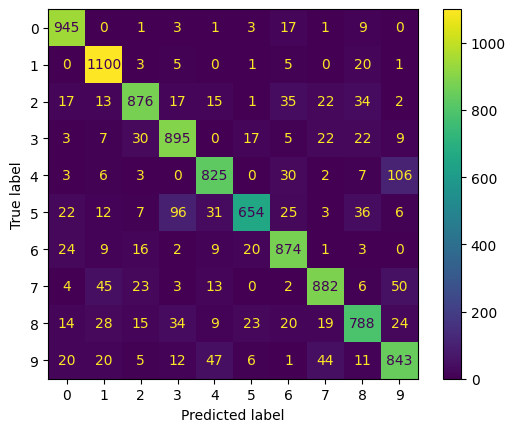

In [14]:
cm = metrics.confusion_matrix(y_test.argmax(axis=1), nn_pred_test.argmax(axis=1))
cm_disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(range(10))
)
cm_disp.plot()

In [15]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
nn_e = shap.DeepExplainer(nn_model, background)
nn_shap_values = nn_e.shap_values(x_test[:6])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


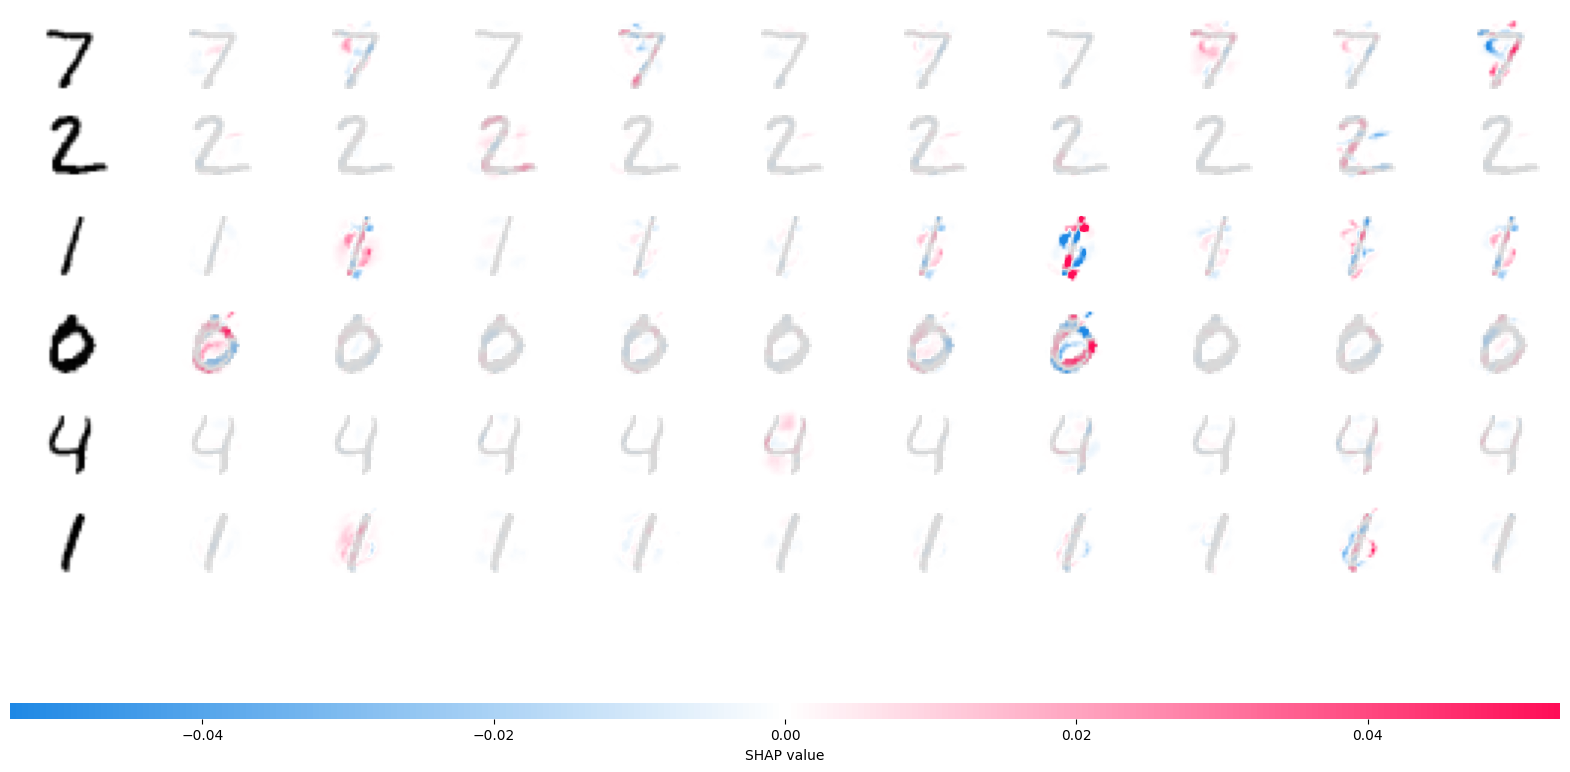

In [16]:
# plot the feature attributions
shap.image_plot(nn_shap_values, -x_test[:6])

## Random Forest

In [17]:
# Flatten image arrays for use in sklearn

x_train_flat_list = []

for img in x_train:
    x_train_flat_list.append(img.ravel())
x_train_sk = np.array(x_train_flat_list)
print(x_train_sk.shape)

x_test_flat_list = []

for img in x_test:
    x_test_flat_list.append(img.ravel())
x_test_sk = np.array(x_test_flat_list)
print(x_test_sk.shape)

(60000, 784)
(10000, 784)


In [18]:
# Convert one-hot targets from tensorflow to class labels

y_train_sk = y_train.argmax(axis=1)
y_test_sk = y_test.argmax(axis=1)

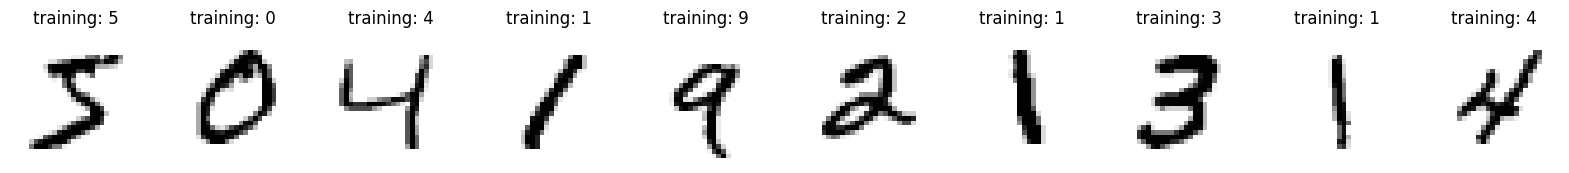

In [19]:
n_images = 10

_, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 3))
for ax, image, label_ar in zip(axes, x_train[:n_images], y_train[:n_images]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    label = label_ar.tolist().index(1)
    ax.set_title(f'training: {label}')

In [20]:
param_grid = {
    'max_depth': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 45, 10))
}
clf = ensemble.RandomForestClassifier(random_state=12345, n_jobs=3)

In [21]:
grid_search = model_selection.GridSearchCV(
    estimator=clf,
    scoring='f1_macro',
    param_grid=param_grid,
    n_jobs=2,
    cv=3,
    verbose=2
)

In [22]:
%%time
grid_search.fit(x_train_sk, y_train_sk)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
CPU times: user 26.6 s, sys: 476 ms, total: 27.1 s
Wall time: 6min 43s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=3, random_state=12345),
             n_jobs=2,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [5, 15, 25, 35]},
             scoring='f1_macro', verbose=2)

[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   4.2s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   3.6s
[CV] END ...................max_depth=5, min_samples_leaf=15; total time=   3.4s
[CV] END ...................max_depth=5, min_samples_leaf=25; total time=   3.5s
[CV] END ...................max_depth=5, min_samples_leaf=25; total time=   3.5s
[CV] END ...................max_depth=5, min_samples_leaf=35; total time=   3.5s
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   6.3s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   6.1s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   5.9s
[CV] END ..................max_depth=10, min_samples_leaf=25; total time=   5.9s
[CV] END ..................max_depth=10, min_samples_leaf=25; total time=   5.7s
[CV] END ..................max_depth=10, min_samples_leaf=35; total time=   5.7s
[CV] END ...................

In [23]:
model = grid_search.best_estimator_
model

RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_jobs=3,
                       random_state=12345)

In [24]:
pred_train = model.predict(x_train_sk)
pred_test = model.predict(x_test_sk)

In [25]:
print(metrics.classification_report(y_train_sk, pred_train))
print()
print(metrics.classification_report(y_test_sk, pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5923
           1       0.99      0.99      0.99      6742
           2       0.99      0.99      0.99      5958
           3       0.99      0.99      0.99      6131
           4       0.99      0.99      0.99      5842
           5       1.00      0.99      0.99      5421
           6       0.99      1.00      0.99      5918
           7       0.99      0.99      0.99      6265
           8       0.99      0.99      0.99      5851
           9       0.99      0.98      0.98      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.95

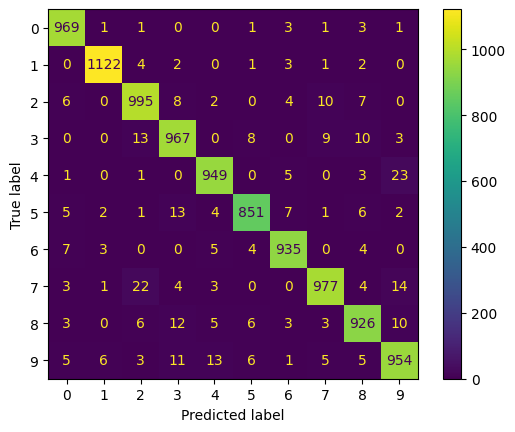

In [26]:
cm = metrics.confusion_matrix(y_test_sk, pred_test)
cm_disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.classes_
)
cm_disp.plot()

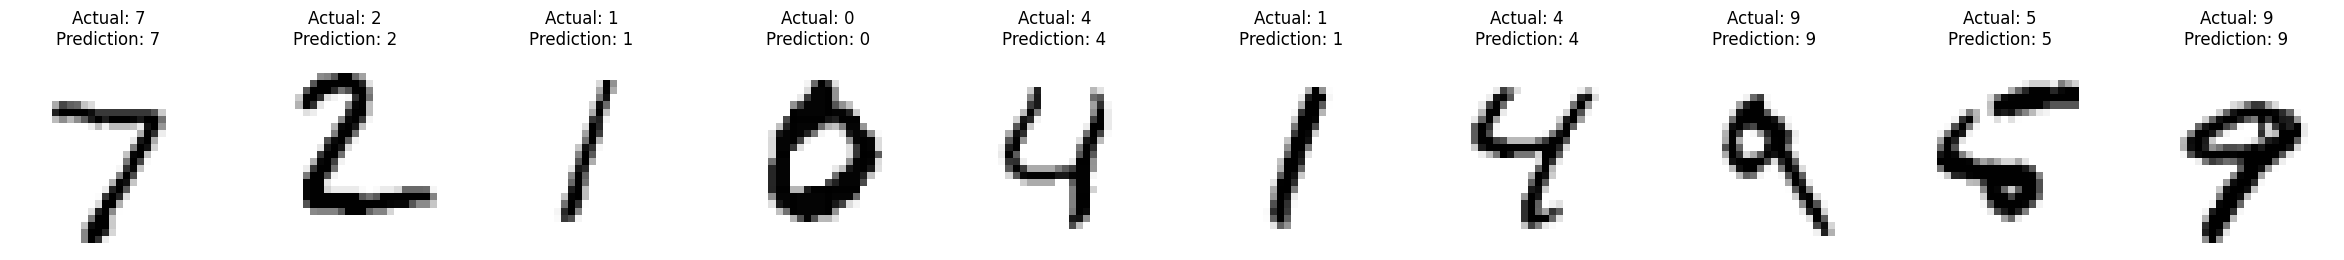

In [27]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 30))
for ax, image, actual, pred in zip(axes, x_test, y_test.argmax(axis=1), pred_test):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {actual}\nPrediction: {pred}')

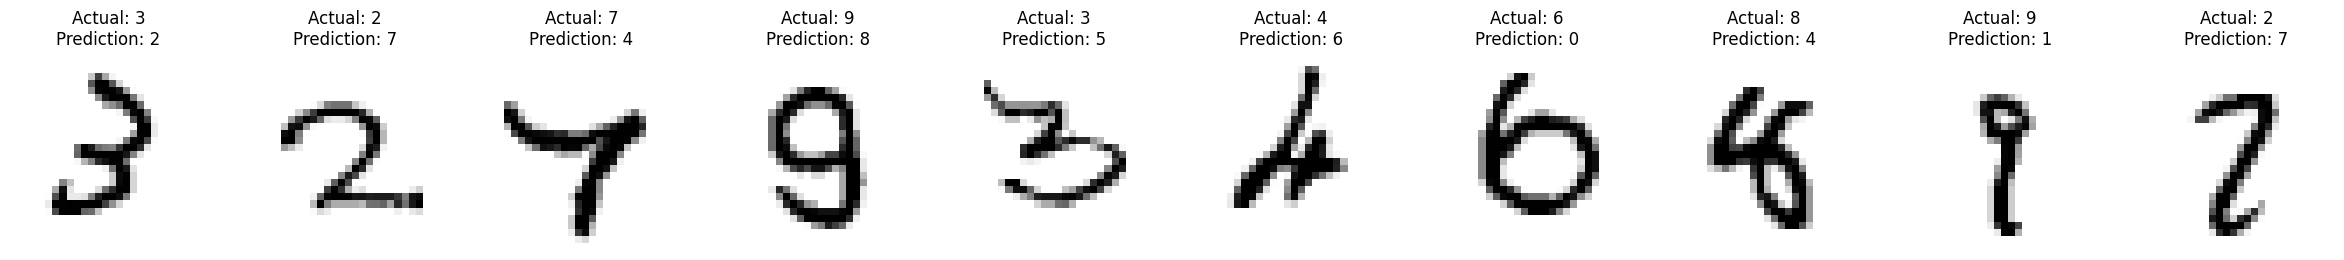

In [28]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 30))

y_test_miss = []
pred_test_miss = []
images_test_miss = []
for image, actual, pred in zip(x_test, y_test.argmax(axis=1), pred_test):
    if actual != pred:
        y_test_miss.append(actual)
        pred_test_miss.append(pred)
        images_test_miss.append(image)
        
for ax, image, actual, pred in zip(axes, images_test_miss, y_test_miss, pred_test_miss):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {actual}\nPrediction: {pred}')

In [29]:
def plot_shap_pixels_tree(model, x, y, num_obs=None, actual_label=None, pred_label=None, act_pred_match=None):
    """Produce grid of plots showing SHAP effects for pixels in digits images.
    
    Parameters
    ----------
    model : object
        Model object to be passed to SHAP explainer
        
    x : np.array
        Array of pixels for input into the model
        
    y : np.array
        Array of labels for image data in `x`
    
    num_obs : int (default None)
        Number of observations to include in plot grid
        
    actual_label : int (default None)
        Value of true label for which data should be filtered
        
    pred_label : int (default None)
        Value of predicted label for which data should be filtered
        
    act_pred_match : bool (default None)
        Indicator for whether results should be filtered for correct or incorrect
        predictions;
            `None` returns all predictions
            `True` returns all correct predictions
            `False` returns all incorrect predictions
    
    Returns
    -------
    None
    """
    # Make copy of x and y data
    x_data = x.copy()
    y_data = y.copy()
    
    # Filter to only images with a specific target label    
    if actual_label:
        assert isinstance(actual_label, int) and 0 <= actual_label <= 9, \
            "`actual_label` must be passed an integer in the interval [0,9]"
        LOGGER.info(f"Filtering where true label is {actual_label}")

        mask = y_test == actual_label
        x_data = x_data[mask]
        y_data = y_data[mask]
             
    # Create predicted labels
    pred_data = model.predict(np.array([img.ravel() for img in x_test]))

    if pred_label:
        assert isinstance(pred_label, int) and 0 <= pred_label <= 9, \
            "`pred_label` must be passed an integer in the interval [0,9]"
        
        LOGGER.info(f"Filtering to where predicted label is {pred_label}")
        mask = pred_data == pred_label
        x_data = x_data[mask]
        y_data = y_data[mask]
        pred_data = pred_data[mask]
        
    # Filter to only matched or mismatched predictions, if desired
    if act_pred_match is None:
        pass
    else:
        assert isinstance(act_pred_match, bool), \
            "`act_pred_match` must be passed as a boolean"
        LOGGER.info(f"Filtering to where predictied label and actual label matching is {act_pred_match}")
                    
        mask = y_data == pred_data
        if not act_pred_match:  # Flip booleans to get mismatches
            mask = ~mask
        x_data = x_data[mask]
        y_data = y_data[mask]
        pred_data = pred_data[mask]
        
    # Limit the number of remaining observations
    if num_obs:
        assert isinstance(num_obs, int) and num_obs > 0, \
            "`num_obs` must be passed a positive integer"
        
        if num_obs < len(x_data):
            num_obs = len(x_data)
            LOGGER.info(f"Using all remaining data since length is less than num_obs of {num_obs}")
                    
        LOGGER.info(f"Filtering to include only {num_obs} results")
        x_data = x_data[:num_obs]
        y_data = y_data[:num_obs]
        pred_data = pred_data[:num_obs]
    else:
        num_obs = len(x_data)
        
    # Produce SHAP outputs
    LOGGER.info("Producing SHAP results")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(np.array([img.ravel() for img in x_data]))
    
    shap.image_plot(
        shap_values=[i.reshape(num_obs, 28, 28, 1) for i in shap_values],
        pixel_values=-x_data,  # Applying negative to convert to black-on-white images
        labels=np.array([list(range(10)) for i in range(num_obs)]),
        true_labels=y_data.argmax(axis=1).tolist(),
        width=25,
        labelpad=1
    )

In [30]:
# Plot feature contributions for first few images
plot_shap_pixels_tree(model, x_test, y_test, num_obs=5)

KeyboardInterrupt: 

In [75]:
# Sample of accurate predictions
plot_shap_pixels_tree(model, x_test, y_test, num_obs=5, act_pred_match=True)

elementwise comparison failed; this will raise an error in the future.


IndexError: invalid index to scalar variable.

In [58]:
mask_num = 5
num_shap = 10

mask = y_test_sk == mask_num

# explain predictions of the model on three images
e = shap.TreeExplainer(model)
shap_values = e.shap_values(x_test_sk[mask][:num_shap])

IndexError: index 2 is out of bounds for axis 1 with size 2

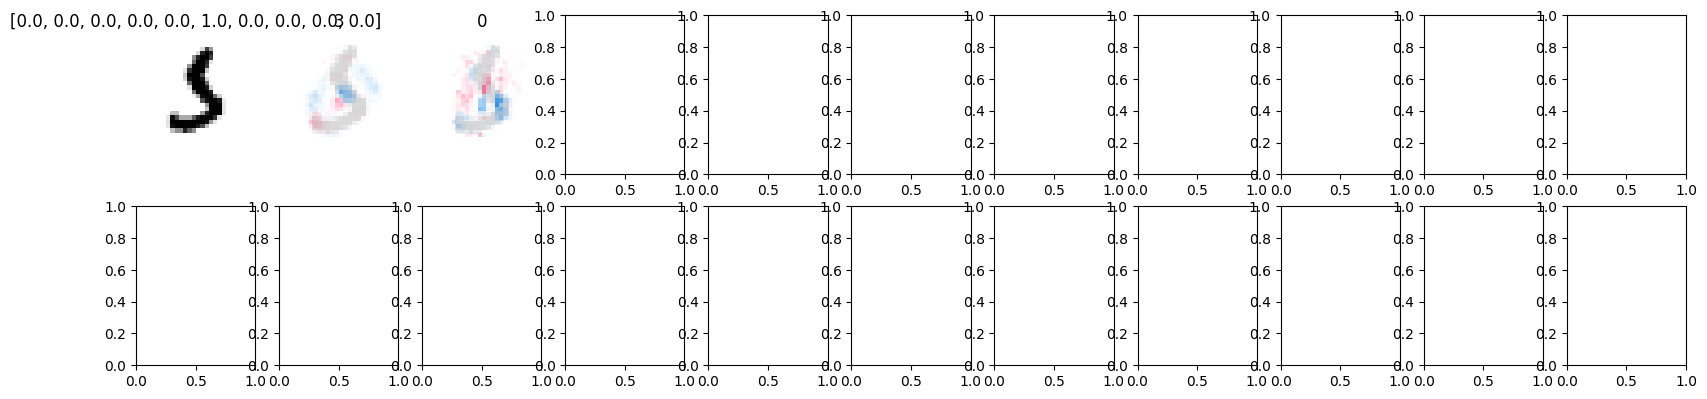

In [79]:
# plot the feature attributions
shap.image_plot([i.reshape(num_shap, 28, 28, 1) for i in shap_values], -x_test[mask][:num_shap], true_labels=y_test[mask][:num_shap].tolist(), labels=pred_test[mask][:num_shap].tolist())

In [70]:
[i.reshape(num_shap, 28, 28, 1) for i in shap_values][0].shape

(2, 28, 28, 1)

In [88]:
shap.image_plot?

In [66]:
mask_num = 5
num_shap = 2

mask = (y_test_sk == mask_num) & (y_test_sk != pred_test)

# explain predictions of the model on three images
e = shap.TreeExplainer(model)
shap_values = e.shap_values(x_test_sk[mask][:num_shap])

[3 0]


IndexError: index 1 is out of bounds for axis 0 with size 1

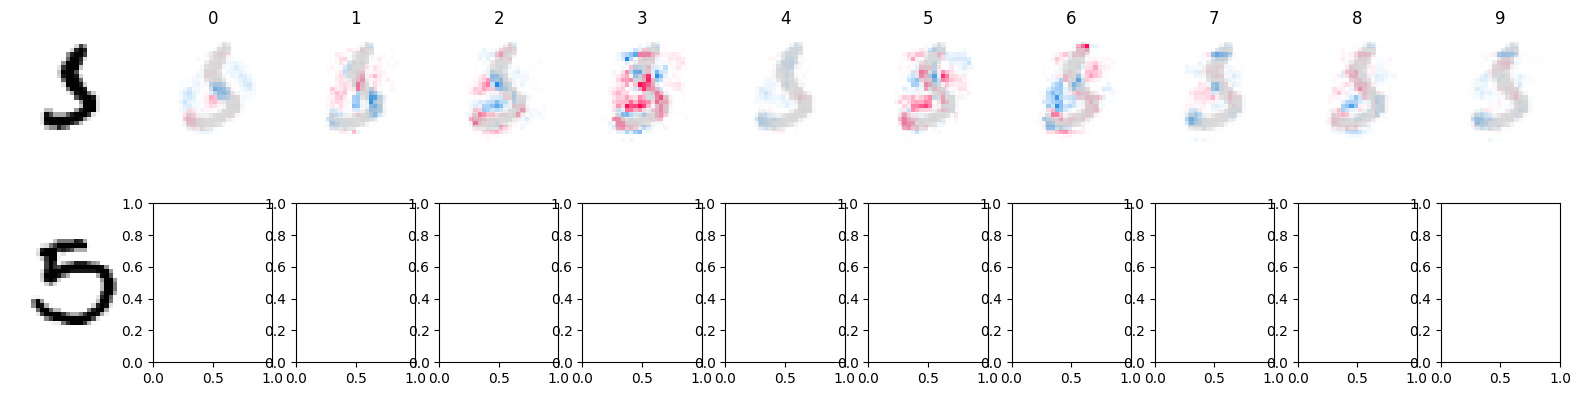

In [67]:
# plot the feature attributions
print(pred_test[mask][:num_shap])
shap.image_plot([i.reshape(num_shap, 28, 28, 1) for i in shap_values], -x_test[mask][:num_shap], labels=list(range(10)))

In [ ]:
shap_values[0].reshape(5, 28, 28, 1)